This notebook is based off of Fatima's `peak_fit_trend_SFR.ipynb` notebook and is designed to compute and plot the SFR as a function of depth inside the V$^2$ voids.

This analysis requires binning the V$^2$ galaxies by their normalized depth inside a void and fitting the resulting distirbution in SFR.  We then compute the ratio of the means of the two skew normal distributions at each depth value.

In [20]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

from scipy.optimize import curve_fit
from scipy.stats import skewnorm

import matplotlib.pyplot as plt
%matplotlib notebook

In [21]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Data

In [2]:
filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdul = fits.open(filename)
data = Table(hdul[1].data)
hdul.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [7]:
# Also only keep those within the redshift limit of the void catalogs
vollim = catalog_main[catalog_main['Z'] <= 0.114]

## Separate galaxies by their LSS classifications

### $V^2$

In [8]:
wall_v2 = vollim['vflag_V2'] == 0
void_v2 = vollim['vflag_V2'] == 1
edge_v2 = vollim['vflag_V2'] == 2
out_v2 = vollim['vflag_V2'] == 9

### VoidFinder

In [9]:
wall_vf = vollim['vflag_VF'] == 0
void_vf = vollim['vflag_VF'] == 1
edge_vf = vollim['vflag_VF'] == 2
out_vf = vollim['vflag_VF'] == 9

# SFR as a function of void depth

Bin the V$^2$ void galaxies by how far from their void boundary they are, and plot the ratio of the high SFR peak mean to the low SFR peak mean in that bin as a function of the distance from the void boundary.  The plot will be cumulative from the inside of a void out, so we are really trying to find the "true" void galaxy population using V$^2$.

In [25]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)


def func_unimodal(x, a, mu, sg, skew):
    """
    One skew normal distribution
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a : float
        amplitude of the skew normal distribution
        
    mu : float
        location of the skew normal distribution
        
    sg : float
        width of the skew normal distribution
        
    skew : float
        skew of the skew normal distribution
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    return a*skewnorm.pdf(x, skew, loc=mu, scale=sg)

In [12]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [28]:
def fit_bimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = np.sqrt(y_data)
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.plot(x_data, func_unimodal(x_data, *popt_[:4]), 'b')
    plt.plot(x_data, func_unimodal(x_data, *popt_[4:]), 'r')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))

<IPython.core.display.Javascript object>


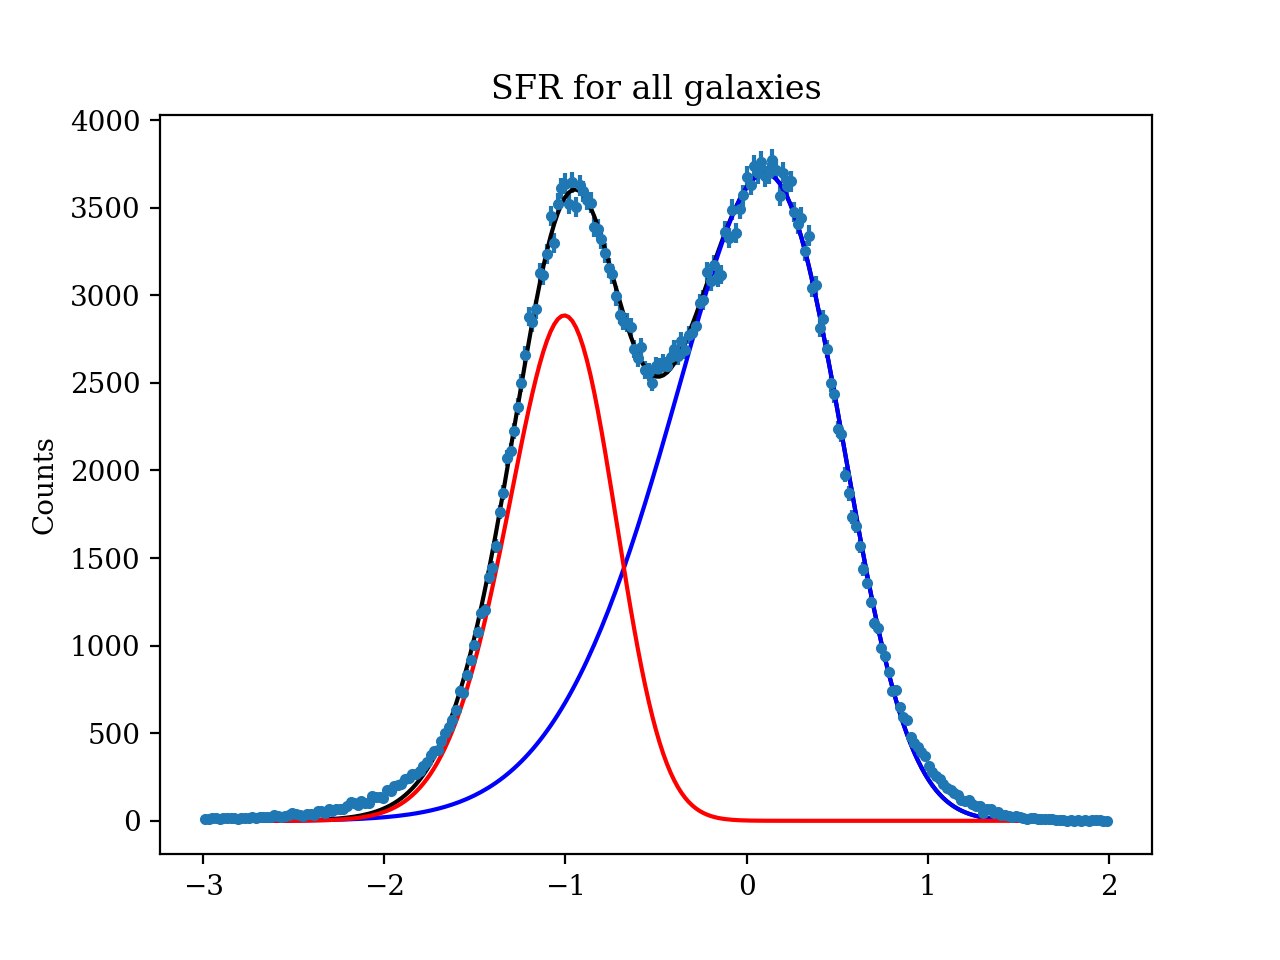

[ 4.53957400e+03  4.91753092e-01  7.53624750e-01 -2.26571826e+00
  2.17894688e+03 -7.84217314e-01  4.08767082e-01 -1.46089471e+00] [6.85205036e+01 8.69517194e-03 2.41242815e-02 1.32212701e-01
 6.72551794e+01 6.46099440e-03 6.43687457e-03 8.30876965e-02]
2.0833798323190384


In [32]:
# What is the ratio of the amplitudes of the two skew normals fit to the SFR for all galaxies in the main footprint?

SFR_bins = np.linspace(-3, 2, 250)

# First, fit the full sample of galaxies with a sum of two skew normal distributions
k = bin_data(vollim['SFR'], bins_=SFR_bins)
SFR_all_fit = fit_bimodal(char_=vollim['SFR'],
                          bins=SFR_bins, 
                          err=k[2], 
                          p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                          label='SFR for all galaxies')

SFR_ratio_all = SFR_all_fit[0][0]/SFR_all_fit[0][4]
print(SFR_ratio_all)